# Open-Science-prize quantum challenge 2021/22 by Quantum Polo Gang

# Abstract

We decide to split the XXX Hamiltonian into two pieces $H=H_1+H_2$ (instead of 6):
$$    H_1=I^{(0)} \otimes \sigma_x^{(1)} \otimes \sigma_x^{(2)}  + I^{(0)}  \otimes  \sigma_y^{(1)} \otimes \sigma_y^{(2)} + I^{(0)}  \otimes \sigma_z^{(0)} \otimes \sigma_z^{(1)}$$
$$ H_2=\sigma_x^{(0)}\otimes \sigma_x^{(1)} \otimes I^{(2)}  +  \sigma_y^{(0)} \otimes \sigma_y^{(1)} \otimes I^{(2)} + \sigma_z^{(0)} \otimes \sigma_z^{(1)} \otimes I^{(2)}$$

so using Trotter's formula (for a fixed number of steps $N$):
$$ e^{-iHt}=e^{-i(H_1 + H_2)t} \simeq \left(e^{-iH_1\frac{t}{N}}e^{-iH_2\frac{t}{N}}\right)^N \equiv (T_{step})^N \equiv T(t)$$

Our main goal is to find the operator $U_{best}$ for which the number of gates is minimum and for which holds (at all times):

$$U_{best}(t) \ket{110} = T(t) \ket{110}$$

This can be intended in two ways:

* $U_{best} = T$ (equality between operators)
* $U_{best} \neq T$, but the two different operators applied to the same vector yield the same result

We followed both approaches, the former will be called *Hilbert Space Decomposition* (HSD) while for the latter we chose the name of *Single State Decomposition* (SSD).

For HSD the best circuit we found is composed of 11 cnots (14 for the Jakarta geometry) while for the SSD approach we reached an even better 4 cnots solution.

Furthermore, referring to qiskit's measurement error mitigation strategy (*https://qiskit.org/textbook/ch-quantum-hardware/measurement-error-mitigation.html*), we tried to model also the noise introduced by the circuit instead of narrowing down to measurement error only.

# Tomography evaluation

model chosen and results

# 1) Decompositions

## 1.1) Single State Decomposition

We start from observing that the hamiltonian preserves the magnetization:
$$m = \sum_i \sigma_z^{(i)}$$
We want to mimic the 3-qubit gate using two 2-qubit gates in succession, thus the subgates must preserve the magnetization too.
$$U_{best} = \left( \mathbb{I}^{(0)} \otimes M^{(1,2)} \right) \cdot \left( M^{(0,1)} \otimes \mathbb{I}^{(2)}  \right)  $$
We search thus the most general form of a 2-qubit magnetization-preserving gate.
Following *reference*, we know that such an operator has the parametric form:

$$ M(\omega,\theta, \phi) = \left[\begin{matrix}e^{ -i \left( \phi + \theta\right)} & 0 & 0 & 0\\ 0 & e^{-  i \left(\phi + \theta\right)} \cos{\left(\omega \right)} & - e^{-  i \left( \phi - \theta\right)} \sin{\left(\omega \right)} & 0\\ 0 & e^{ i \left( \phi - \theta\right)} \sin{\left(\omega \right)} & e^{ i \left( \phi + \theta\right)} \cos{\left(\omega \right)} & 0\\ 0 & 0 & 0 & e^{ i \left( \phi + \theta\right)}\end{matrix}\right] $$

and can be decomposed with 2 c-nots.

Fixed the initial state to $\ket{110}$, we have that $M^{(1,2)}M^{(0,1)}\ket{110}$ spans the whole magnetization eigenspace. 
$$U_{best} = \left(  \mathbb{I} \otimes M(\omega_2,\theta_2, \phi_2)\right)     \cdot     \left( M(\omega_1,\theta_1, \phi_1) \otimes \mathbb{I} \right)   $$

So taking: $$T\ket{110} = \alpha \ket{011} + \beta \ket{101} + \gamma \ket{110}$$

and: 

$$\begin{align*}

U_{best}\ket{110} =\; &e^{i(\theta_1 - \phi_1 + \theta_2 - \phi_2)}\sin(\omega_1)\sin(\omega_2) \ket{011} +\\
& e^{i(\theta_1-\phi_1-\theta_2-\phi_2-\pi)}\sin(\omega_1)\cos(\omega_2) \ket{101} + \\
&e^{i(\theta_1+\phi_1+\theta_2+\phi_2)}\cos(\omega_2) \ket{110}

\end{align*}$$

Matching the amplitudes and solving the system for $\{\omega, \theta, \phi \}_{1,2}$ we get the parameters for the gates $M^{(0,1)}$ and $M^{(1,2)}$.


## Circuits:

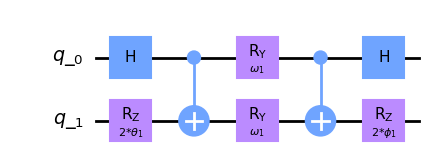

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter

def get_M(theta, phi, omega, name="M"): # defining the M matrix

    qr=QuantumRegister(2, name="q_")
    M_qc=QuantumCircuit(qr, name=name)

    M_qc.rz(2*theta,qr[1])
    M_qc.h(qr[0])
    M_qc.cx(qr[0],qr[1])
    M_qc.ry(omega,qr)
    M_qc.cx(qr[0],qr[1])
    M_qc.h(qr[0])
    M_qc.rz(2*phi,qr[1])

    return M_qc

theta_1, phi_1, omega_1  = Parameter(r'$\theta_1$'), Parameter(r'$\phi_1$'), Parameter(r'$\omega_1$')

M1_qc = get_M(theta_1, phi_1, omega_1, name=r"$M_1$")

M1_qc.draw(output="mpl", style={"figwidth":6, "fontsize":11})

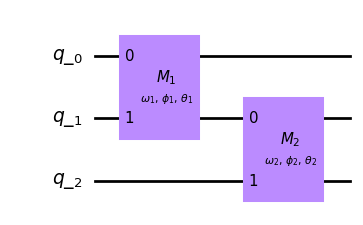

In [2]:
theta_2, phi_2, omega_2  = Parameter(r'$\theta_2$'), Parameter(r'$\phi_2$'), Parameter(r'$\omega_2$')
M2_qc = get_M(theta_2, phi_2, omega_2, name=r"$M_2$")

#building the circuit of U_best
U_best_qr = QuantumRegister(3, name = "q_")
U_best_qc = QuantumCircuit(U_best_qr, name = r"$U_{best}$")

U_best_qc.append(M1_qc, [U_best_qr[0],U_best_qr[1]])
U_best_qc.append(M2_qc, [U_best_qr[1],U_best_qr[2]])

U_best_qc.draw(output = "mpl", style={"figwidth":5, "fontsize":11})

## 1.2) Hilbert Space Decomposition

qui descriviamo teoricamente la hilbert state decomposition

## Circuits:

# 2) Mitigation

The following haphazard processes affect the performance of the circuit:
* measurement noise
* gate noise
* state preparation noise 

we neglect the noise introduced by state mispreparation, so we assume the following model:
$$ \ket{\psi_{noisy}} =  U_{noisy} \ket{\psi_0} = M N U \ket{\psi_0}  = M N \ket{\psi_{ideal}} $$

Where $N$ (*Circuit Noise Matrix*) and $M$ (*Measurment Noise Matrix*) are the unitary matrices that rapresent the noise of circuit and measure.

Since the measurment process gives us squared amplitudes (probabilities), one can write:

$$ \| \ket{\psi_{noisy}} \| = \| M N \ket{\psi_{ideal}} \| =  \| M \| \| N \| \| \ket{\psi_{ideal}} \| $$

So, characterizing the probability matrices $\| M \|$ and $\| N \|$ we could mitigate the results.

### Notation:
* we use $ \|A\| \equiv |A|^2$ to intend the squared module element by element of A, where A is a complex matrix or vector.

## 2.1) *Circuit Itself Calibration* (CIC)

We can built the matrix $ \tilde{U} = \|MNU\| $, just preparing all the $2^n$ computational basis states and evolve them with the circuit $U_{noisy}$ itself.
$$ \tilde{U}_{i,j} =  \bra{j} MNU \ket{i} $$

So, the *calibration matrix* is:
$$ C = \tilde{U} \| U \|^{-1}  = \| MN \| \|U\| \|U\|^{-1} = \| MN \| $$

## Circuits:

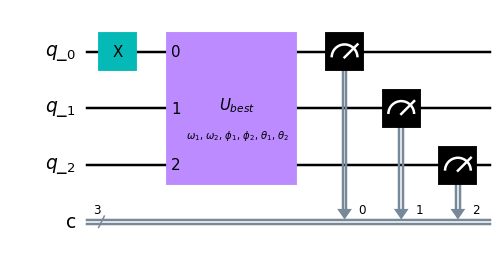

In [3]:
calib_circuits_CIC = []

state_labels = ['000', '001', '010', '011', '100', '101', '110', '111']  

for state in state_labels:
    cr_cal_itself = ClassicalRegister(3, name = "c")
    qr_cal_itself = QuantumRegister(3, name = "q_")
    qc_cal_itself = QuantumCircuit(qr_cal_itself, cr_cal_itself, name=f"mcalcal_{state}")
    # first we prepare the initial state.
    for qubit in [0,1,2]:
        if state[::-1][qubit] == "1":
            qc_cal_itself.x(qr_cal_itself[qubit])
    # then we append the circuit.
    qc_cal_itself.append(U_best_qc, qr_cal_itself)
    qc_cal_itself.measure(qr_cal_itself, cr_cal_itself)

    calib_circuits_CIC.append(qc_cal_itself)
# example: for i = 1 we should preper the state |001> (gate x on first qubit).
calib_circuits_CIC[1].draw(output="mpl", style={"figwidth":7, "fontsize":12})


## 2.2) *Noisy Identity Calibration* (NIC)
CAMBIARE!!!
In order to evaluate $ C = \|MN\| $, for all computational base states we use the following scheme:
* prepare the initial state in an eigenvector of $U$: $U\ket{\lambda} = \lambda \ket{\lambda}$.
* we define an operator $O_{i, \lambda}$ such that: $O_{i, \lambda} \ket{\lambda} = \ket{i}$.

So, running the circuits:
$$ C_{i,j} = \bra{j} MNO_{i, \lambda}U \ket{\lambda} = \bra{j} MN \ket{i} $$ 

Where we assume $O_{i, \lambda}$ an noiseless operator.

## Circuits:

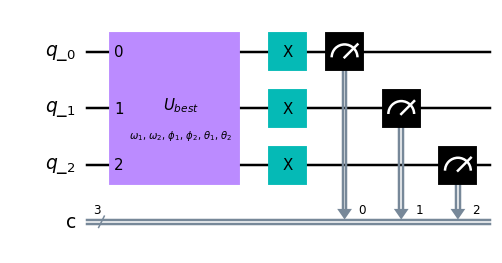

In [4]:
calib_circuits_NIC = []

for state in state_labels:
    cr_cal_id = ClassicalRegister(3, name = "c")
    qr_cal_id = QuantumRegister(3, name = "q_")
    qc_cal_id = QuantumCircuit(qr_cal_id, cr_cal_id, name=f"mcalcal_{state}")
    # first we append the circuit.
    qc_cal_id.append(U_best_qc, qr_cal_id)
    # than we permute the state.
    for qubit in range(3):
        if state[::-1][qubit] == "1":
            qc_cal_id.x(qr_cal_id[qubit])
        
    qc_cal_id.measure(qr_cal_id, cr_cal_id)

    calib_circuits_NIC.append(qc_cal_id)
# example: for i = 7 we should get the final state |111> (gate x on all qubits).
calib_circuits_NIC[7].draw(output="mpl", style={"figwidth":7, "fontsize":12})


## 2.3) *Fast Tomography Circuits Calibration*

Using NIC or CIC for each tomography base we should run $2^n$ circuit to calibrate it, so the total number of run would be $2^n \cdot 3^n$ calibration circuits, that is computationally high-expensive.

The *Fast Tomography Circuits Calibration* needs only $2^n$ calibration circuits.

The idea is to compute just once the calibration matrix in the computational basis. Then to compute the calibration matrix in a basis $B$ at will one can just use the following: $$ \tilde{C} = M B M^{-1} C B^{-1} $$
We want to infer how the change of basis affects the noise.
We assume that the measurement noise acts on the circuit after the change of basis which in turn happens before the circuit noise:
$$ \ket{\psi_{ideal}} = BU\ket{\psi_0}$$
$$ \ket{\psi_{noisy}} = \tilde{U} \ket{\psi_0} = MHNU\ket{\psi_0} = MBNB^{-1}\ket{\psi_{ideal}}$$
Since the previous strategies can estimate jointly $C \equiv MN$ and not $N$ alone, we can do so
$$\tilde{C} = MBNB^{-1} = MBM^{-1}MNB^{-1} = MBM^{-1} \cdot C B^{-1} $$
And the new matrix $\tilde{C}$ is the noise matrix in the new basis. The remarkable fact is that once $C$ is computed by one of the methods previously stated, it is possible to obtain the noise in every basis, given that we know the change of base matrix $B$.



# 3) results and conclusion

In [5]:
import numpy as np
import sympy
from scipy.linalg import expm

# defining the evolution paramiters
N_Trotter_Steps = 99
evolution_time = np.pi

In [6]:
X = np.array([[0,1],[1,0]])  #defining the pauli matrices
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
Id = np.eye(2)

# defining the two hamiltonian pizes: 
H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.
trotter_step_matrix_= expm(-evolution_time/N_Trotter_Steps*H1*1j).dot(expm(-evolution_time/N_Trotter_Steps*H2*1j))
trotterized = np.linalg.matrix_power(trotter_step_matrix_, N_Trotter_Steps)

sympy.Matrix(trotterized).n(3, chop=True)

Matrix([
[1.0,                    0,                    0,                    0,                    0,                    0,                    0,   0],
[  0,      1.0 + 0.00105*I, 0.000102 + 0.00105*I,                    0, -9.87e-5 - 0.00211*I,                    0,                    0,   0],
[  0, -9.87e-5 + 0.00105*I,      1.0 - 0.00211*I,                    0, 0.000102 + 0.00105*I,                    0,                    0,   0],
[  0,                    0,                    0,      1.0 + 0.00105*I,                    0, -9.87e-5 + 0.00105*I, 0.000102 - 0.00211*I,   0],
[  0, 0.000102 - 0.00211*I, -9.87e-5 + 0.00105*I,                    0,      1.0 + 0.00105*I,                    0,                    0,   0],
[  0,                    0,                    0, 0.000102 + 0.00105*I,                    0,      1.0 - 0.00211*I, -9.87e-5 + 0.00105*I,   0],
[  0,                    0,                    0, -9.87e-5 - 0.00211*I,                    0, 0.000102 + 0.00105*I,      1.0 + 

## 3.1) *Single State Decomposition* results

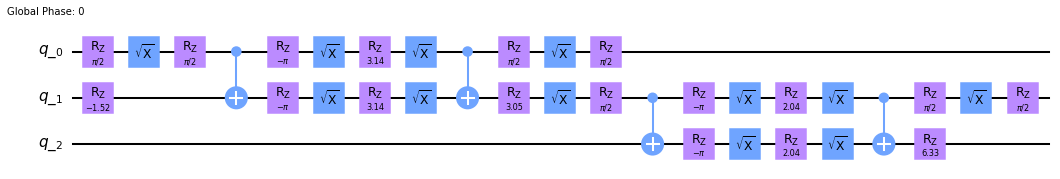

In [7]:
import lib.utility as utility

r1, r2, f1, f2, a1, a2 = utility.get_gates_parameters(trotterized, initial_state={"110": 1.0})

M1_qc = get_M(r1,f1,a1)
M2_qc = get_M(r2,f2,a2)

qr_U = QuantumRegister(3 ,name="q_")
qc_U = QuantumCircuit(qr_U, name="U")

qc_U.append(M1_qc, [qr_U[0],qr_U[1]])
qc_U.append(M2_qc, [qr_U[1],qr_U[2]])

from qiskit import transpile
qc_U=transpile(qc_U, basis_gates=["cx","rz","x","sx"])
qc_U.draw(output="mpl", style={"figwidth":15, "fontsize":12})

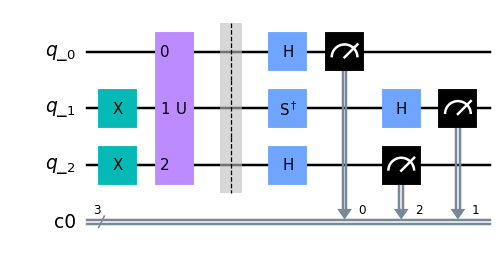

In [8]:
qr_evo = QuantumRegister(3, name="q_")
qc_evo = QuantumCircuit(qr_evo, name=r"$U_{best}$")

qc_evo.x([qr_evo[1],qr_evo[2]])
qc_evo.append(qc_U, qr_evo)

from qiskit.ignis.verification.tomography import state_tomography_circuits

qcs_tomo = state_tomography_circuits(qc_evo, qr_evo)
qcs_tomo[3].draw(output="mpl", style={"figwidth":7, "fontsize":12})

In [9]:
# building the calibration circuits
calib_circuits_NIC = utility.get_calibration_circuits(qc_U, method="NIC")
calib_circuits_CIC = utility.get_calibration_circuits(qc_U, method="CIC")

In [14]:
from qiskit import IBMQ, execute
from qiskit.providers.aer import QasmSimulator

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')
backend_sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')

shots = 20000

job_tomography=execute(qcs_tomo, backend_sim_noisy_jakarta, shots=shots, initial_layout=[1,3,5])
job_NIC=execute(calib_circuits_NIC, backend = backend_sim_noisy_jakarta, shots=shots, initial_layout=[1,3,5])
job_CIC=execute(calib_circuits_CIC, backend = backend_sim_noisy_jakarta, shots=shots, initial_layout=[1,3,5])

ibmqfactory.load_account:WARNING:2022-04-12 02:50:48,542: Credentials are already in use. The existing account in the session will be replaced.


In [15]:
# building the matrices
from qiskit.utils.mitigation.fitters import CompleteMeasFitter

meas_fitter_NIC = CompleteMeasFitter(job_NIC.result(), state_labels=state_labels)
meas_fitter_CIC = CompleteMeasFitter(job_CIC.result(), state_labels=state_labels)

U_tilde_identity=meas_fitter_NIC.cal_matrix
U_tilde_itself=meas_fitter_CIC.cal_matrix

U_ideal = utility.matrix_from_cirquit(qc_U, output_type = "numpy")

#defining the tomography basis circuits.
qr_basi = QuantumRegister(3)
qc_basi = QuantumCircuit(qr_basi)
tomography_basis = state_tomography_circuits(qc_basi, qr_basi)

C_matrices_NIC = []
C_matrices_CIC = []

U_ideal_abs = np.abs(U_ideal)**2
U_ideal_abs_inv = np.linalg.inv(U_ideal_abs)

C_itself = np.dot(U_tilde_itself, U_ideal_abs_inv)
C_identity = U_tilde_identity

# building the fast tomography circuits calibration.
for basis in tomography_basis:

    basis.remove_final_measurements()
    base_matrix_amplitudes = utility.matrix_from_cirquit(basis, output_type="numpy")
    base_matrix_amplitudes_inverse = np.linalg.inv(base_matrix_amplitudes)
    
    base_matrix = np.abs(base_matrix_amplitudes)**2
    base_matrix_inverse = np.abs(base_matrix_amplitudes_inverse)**2

    C_aus_itself = np.linalg.multi_dot([base_matrix, C_itself,  base_matrix_inverse])
    C_aus_identity = np.linalg.multi_dot([base_matrix, C_identity,  base_matrix_inverse])

    C_matrices_NIC.append(np.asarray(C_aus_identity))
    C_matrices_CIC.append(np.asarray(C_aus_itself))

import copy
meas_fitters_identity = []
meas_fitters_itself = []

for tomography_basis in range(3**3):
    meas_fitter_aus = copy.deepcopy(meas_fitter_NIC)
    meas_fitter_aus._tens_fitt.cal_matrices[0]=C_matrices_NIC[tomography_basis]
    meas_fitters_identity.append(meas_fitter_aus)

    meas_fitter_aus = copy.deepcopy(meas_fitter_CIC)
    meas_fitter_aus._tens_fitt.cal_matrices[0]=C_matrices_CIC[tomography_basis]
    meas_fitters_itself.append(meas_fitter_aus)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [16]:
from qiskit.opflow import One, Zero
target_state = (One^One^Zero).to_matrix()

raw_res = job_tomography.result()
NIC_res = copy.deepcopy(raw_res)
CIC_res = copy.deepcopy(raw_res)

for i in range(27):

    old_counts=raw_res.get_counts(i)
    new_counts_NIC = meas_fitters_identity[i].filter.apply(old_counts, method="least_squares")
    NIC_res.results[i].data.counts = new_counts_NIC

    new_counts_CIC = meas_fitters_itself[i].filter.apply(old_counts, method="least_squares")
    CIC_res.results[i].data.counts = new_counts_CIC

In [17]:
fid_raw = utility.fidelity_count(raw_res, qcs_tomo, target_state)
fid_NIC = utility.fidelity_count(NIC_res, qcs_tomo, target_state)
fid_CIC = utility.fidelity_count(CIC_res, qcs_tomo, target_state)

print(f"fidelity of the raw results is: {fid_raw} \nfidelity of the NIC method results is: {fid_NIC}\nfidelity of the CIC method results is: {fid_CIC}")

fidelity of the raw results is: 0.8660455017586653 
fidelity of the NIC method results is: 0.9939431440463293
fidelity of the CIC method results is: 0.9999110737463361


## 3.2) *Hilbert Space Decomposition* results